# Drowsiness Detection Performance Analyzer
This notebook analyzes the results of our synthesized PERCLOS calculator in hopes of grading its accuracy at accessing drowsiness.
We collected data from the PERCLOS calculator while users completed reaction time tests. 

## Prerequisites
If you encounter errors, please ensure you have all required libraries:
```bash
pip install pandas matplotlib opencv-python 
```

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from io import BytesIO
import os

# Set Plot Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Configuration & Data Loading

In [ ]:
# --- USER CONFIGURATION ---
DATA_DIR = './data/'                   # Path to data directory
# Drowsy Dataset
DROWSY_DATASET_ID = '20251208_001154'               
# Alert Dataset
ALERT_DATASET_ID = '20251208_001154'  

# Construct paths dynamically
class Dataset:
    def __init__(self, id):
        self.DATASET_ID = id
        self.PERCLOS_DATA = os.path.join(DATA_DIR, f'data_{id}.csv')
        self.REACTION_DATA = os.path.join(DATA_DIR, f'reaction_time_data_{id}.csv')
        self.VIDEO = os.path.join(DATA_DIR, f'video_{id}.mp4')
    
DROWSY_DATASET = Dataset(DROWSY_DATASET_ID)
ALERT_DATASET = Dataset(ALERT_DATASET_ID)

PERCLOS data

In [ ]:
def load_data(dataset):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    # Ensure Timestamp is actually a datetime object (if it's a string)
    try:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    except:
        pass
    return df

try:
    df = load_data(CSV_PATH)
    print(f"Loaded {len(df)} rows of data.")
    print(df.describe())
    print("\nFirst 5 rows:")
    print(df.head())
except FileNotFoundError as e:
    print(e)

Loaded 7052 rows of data.
                           Timestamp  Selected_EAR   Smooth_EAR     Threshold  \
count                           7052   7052.000000  7052.000000  7.052000e+03   
mean   2025-12-08 00:16:14.757730304     22.941492    22.941626  2.079000e+01   
min       2025-12-08 00:12:25.323000      8.670000    12.270000  2.079000e+01   
25%       2025-12-08 00:14:16.220000     21.795000    21.850000  2.079000e+01   
50%    2025-12-08 00:16:14.785999872     23.370000    23.520000  2.079000e+01   
75%    2025-12-08 00:18:13.022749952     25.230000    24.940000  2.079000e+01   
max       2025-12-08 00:20:09.352000     31.810000    31.080000  2.079000e+01   
std                              NaN      3.327250     2.945859  3.552966e-15   

       Pitch_Ratio  Pitch_Threshold    Yaw_Ratio  PERCLOS_Score  
count  7052.000000     7.052000e+03  7052.000000    7052.000000  
mean      6.290393     5.330000e+00     0.977019      17.288911  
min       5.370000     5.330000e+00     0.6800

C:\Users\jjluk\AppData\Local\Temp\ipykernel_46592\3093958912.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


Reaction Time Data

In [ ]:
# --- Configuration ---
REACTION_CSV_PATH = os.path.join(DATA_DIR, f'reaction_time_data_{DROWSY_DATASET_ID}.csv')
FAILURE_THRESHOLD_MS = 500  # Reaction times > 1000ms are lapses/failures

# 1. Load Data
try:
    reaction_df = pd.read_csv(REACTION_CSV_PATH)
    
    # Parse Timestamp (UTC -> EST -> Naive)
    reaction_df['Timestamp'] = (
        pd.to_datetime(reaction_df['Timestamp'])
        .dt.tz_convert('US/Eastern')
        .dt.tz_localize(None)
    )
    
    # 2. Identify Failures
    # Create a 'Status' column: 'Success' or 'Failure' based on the threshold
    reaction_df['Status'] = np.where(
        reaction_df['Reaction Time (ms)'] > FAILURE_THRESHOLD_MS, 
        'Failure', 
        'Success'
    )
    
    print(f"Loaded {len(reaction_df)} tests.")
    print(f"Lapses detected (> {FAILURE_THRESHOLD_MS}ms): {len(reaction_df[reaction_df['Status']=='Failure'])}")

    # 3. Merge with Sensor Data
    # Sort first
    df = df.sort_values('Timestamp')
    reaction_df = reaction_df.sort_values('Timestamp')

    # Merge nearest sensor reading within 2 seconds
    merged_analysis = pd.merge_asof(
        reaction_df, 
        df[['Timestamp', 'PERCLOS_Score', 'State']], 
        on='Timestamp', 
        direction='nearest',
        tolerance=pd.Timedelta('2s') 
    )
    merged_analysis.dropna(subset=['PERCLOS_Score'], inplace=True)

except FileNotFoundError:
    print(f"File not found: {REACTION_CSV_PATH}")
except Exception as e:
    print(f"Error: {e}")

Loaded 100 tests.
Lapses detected (> 500ms): 3


## 2. Global State Distribution
How often was the driver in each state?

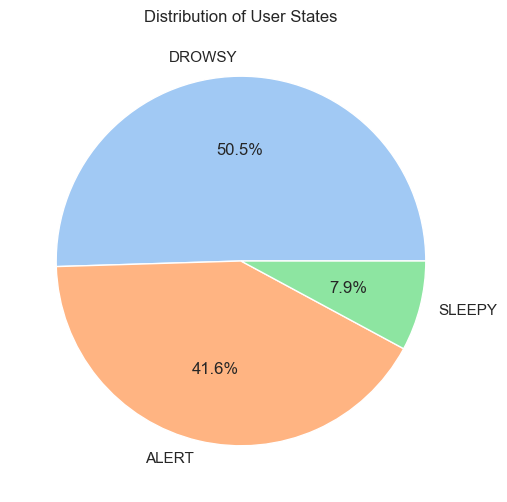

In [33]:
state_counts = df['State'].value_counts()

plt.figure(figsize=(6, 6))
# Using Pandas plotting
state_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of User States')
plt.ylabel('') # Hide the y-label for cleaner look
plt.show()

## 3. Temporal Analysis: EAR vs Threshold
This is the most critical graph. It shows the raw eye openness (Selected_EAR), the smoothed version (used to prevent flickering), and the Trigger Threshold.

* **Green Line**: Smoothed EAR
* **Red Dashed Line**: The Threshold (if EAR drops below this, eyes are closed)


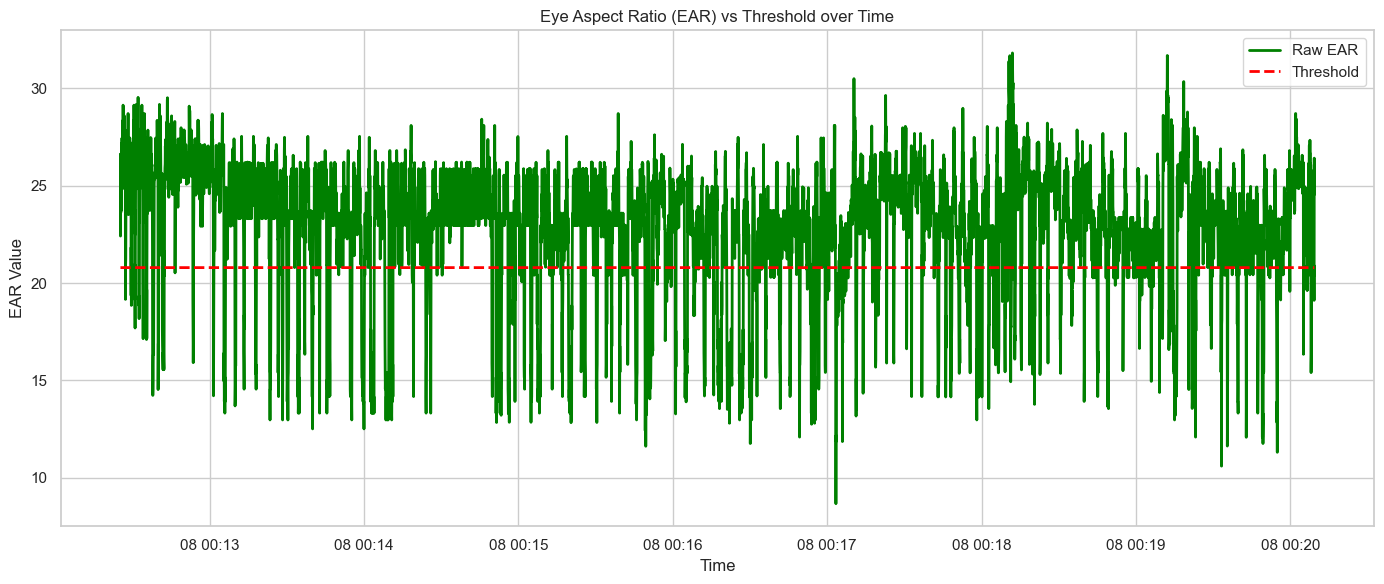

In [34]:
plt.figure(figsize=(14, 6))

# Plot Raw EAR (Faint)
plt.plot(df['Timestamp'], df['Selected_EAR'], label='Raw EAR', color='green', linewidth=2)

# Plot Threshold
plt.plot(df['Timestamp'], df['Threshold'], label='Threshold', color='red', linestyle='--', linewidth=2)

plt.title('Eye Aspect Ratio (EAR) vs Threshold over Time')
plt.xlabel('Time')
plt.ylabel('EAR Value')
plt.legend()
plt.tight_layout()
plt.show()

## 4. PERCLOS Plot
**PERCLOS** (Percentage of Eyelid Closure) is the standard safety metric.

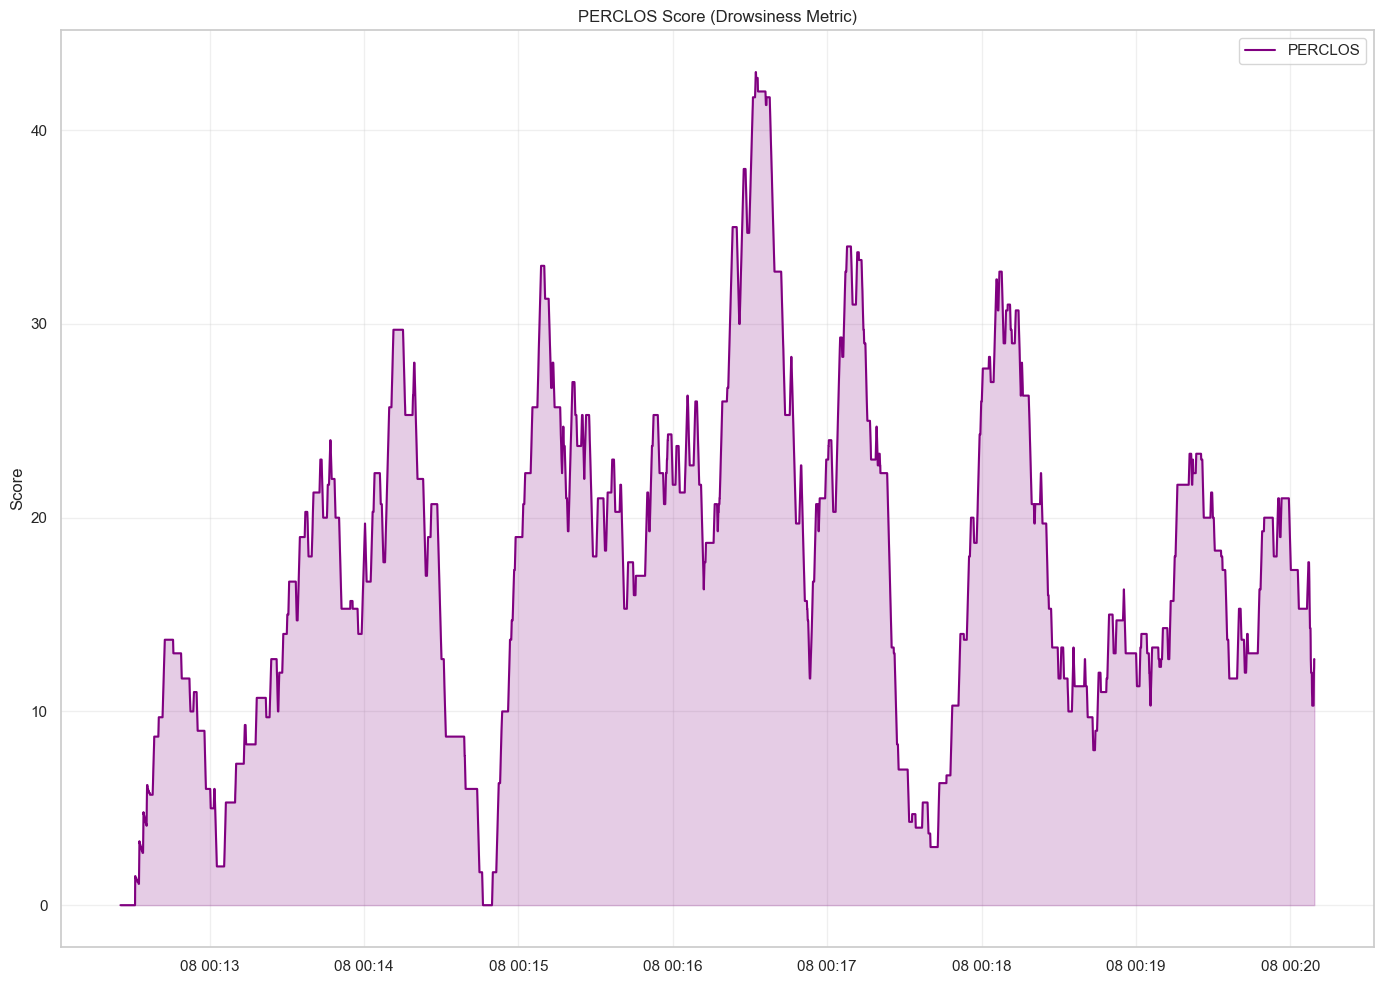

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 10), sharex=True)

# PERCLOS Plot
ax1.plot(df['Timestamp'], df['PERCLOS_Score'], label='PERCLOS', color='purple')
ax1.fill_between(df['Timestamp'], df['PERCLOS_Score'], color='purple', alpha=0.2)
ax1.set_title("PERCLOS Score (Drowsiness Metric)")
ax1.legend(loc="upper right")
ax1.set_ylabel("Score")
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

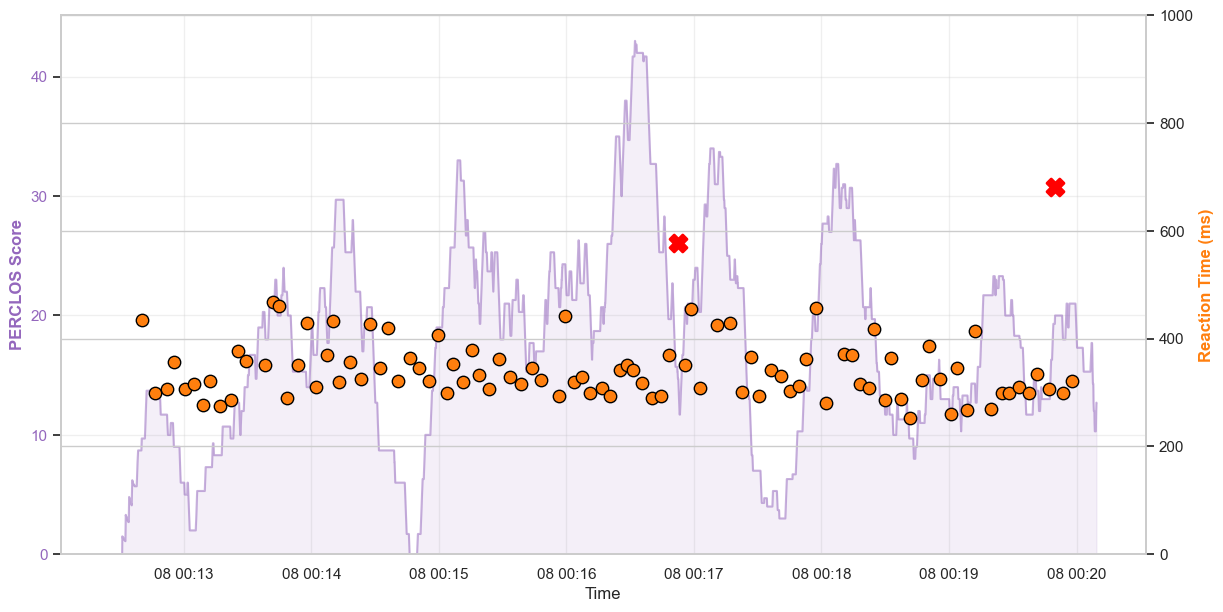

In [36]:
import matplotlib.lines as mlines

if 'merged_analysis' in locals() and not merged_analysis.empty:
    # Calculate Correlation
    corr = merged_analysis['Reaction Time (ms)'].corr(merged_analysis['PERCLOS_Score'])
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # --- Plot 1: PERCLOS (Left Axis) ---
    color1 = 'tab:purple'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('PERCLOS Score', color=color1, fontsize=12, fontweight='bold')
    
    # Plot the continuous PERCLOS signal
    ax1.plot(df['Timestamp'], df['PERCLOS_Score'], color=color1, alpha=0.5, label='PERCLOS')
    ax1.fill_between(df['Timestamp'], df['PERCLOS_Score'], color=color1, alpha=0.1)
    
    # Set standard PERCLOS limits
    ax1.set_ylim(0)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    # --- Plot 2: Reaction Time (Right Axis) ---
    ax2 = ax1.twinx() 
    ax2.set_ylim(0, 1000)
    color2 = 'tab:orange'
    ax2.set_ylabel('Reaction Time (ms)', color=color2, fontsize=12, fontweight='bold')
    
    # Separate data for plotting different markers
    successes = merged_analysis[merged_analysis['Status'] == 'Success']
    failures = merged_analysis[merged_analysis['Status'] == 'Failure']
    
    # 2a. Plot Valid Responses (Orange Dots)
    ax2.scatter(
        successes['Timestamp'], 
        successes['Reaction Time (ms)'], 
        color='tab:orange', 
        s=80, 
        edgecolors='black', 
        label='Valid Reaction',
        zorder=10
    )
    
    # 2b. Plot Failures/Lapses (Red 'X')
    # These plot at their actual high value (e.g., 1500ms)
    ax2.scatter(
        failures['Timestamp'], 
        failures['Reaction Time (ms)'], 
        color='red', 
        marker='X', 
        s=150, 
        linewidths=2,
        label='Lapse (>1s)',
        zorder=11
    )
    
    # Add a horizontal line at the threshold to visually separate the